### Takeover library initialization and dataset preparation from MLP_nn.ipynb

In [204]:
#import libraries

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np

%matplotlib inline

In [205]:
#load data

words = open('names.txt').read().splitlines()
print(len(words))

32033


In [206]:
#encoder and decoder
chars  = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}

In [207]:
#prepare dataset
batch_size = 3

def build_dataset(words):
    X, Y = [], []

    for word in words:
        context = [0] * batch_size
        for w in word + ".":
            ix = stoi[w]

            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_trn, Y_trn = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

print(X_trn.shape, Y_trn.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Implement neural net class similar to pytorch to understand the modules in nn.module of pytorch

In [214]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
class Linear:

    def __init__(self, fan_in, fan_out, bias =True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1D:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.dim = dim
        self.eps = eps
        self.momentum = momentum
        self.Training = True

        #batch parameters (trained by backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        #buffer (trained by momentum)
        self.running_var = torch.ones(dim)
        self.running_mean = torch.zeros(dim)

    def __call__(self,x):
        if self.Training:
            xvar = x.var(0, keepdim=True)
            xmean = x.mean(0, keepdim=True)
        else:
            xvar = self.running_var
            xmean = self.running_mean

        hat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * hat + self.beta

        if self.Training:
            with torch.no_grad():
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
vocab_size = 27
n_embedding = 10
n_hidden = 100

C = torch.randn(vocab_size, n_embedding)


layers = [
    Linear(n_embedding * batch_size, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1D(vocab_size),
]

# The following layers include BatchNorm1D and Tanh activations after each Linear layer except the last one.
# layers = [
#     Linear(n_embedding * batch_size, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size, bias=False), BatchNorm1D(vocab_size),
# ]

with torch.no_grad():

    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


47024


In [215]:
#training the deep neural net

max_iter = 100001
mini_batch = 32
lossi = []
ud = []

for i in range(max_iter):

    ix = torch.randint(0, X_trn.shape[0], (mini_batch,), generator=g)

    X, Y = X_trn[ix], Y_trn[ix]

    #embedding the input to vector embedding
    emb = C[X]
    x = emb.view(emb.shape[0],-1) #concatenate the to mini batch size to pass through layer
    # forward pass Xw + b , pass through activation tanh
    for layer in layers:
        x = layer(x)
    #calculate the loss
    loss = F.cross_entropy(x, Y)

    #backward pass
    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 80000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_iter:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 100001: 3.2795
  10000/ 100001: 2.0835
  20000/ 100001: 2.6074
  30000/ 100001: 2.3199
  40000/ 100001: 2.0207
  50000/ 100001: 2.0564
  60000/ 100001: 1.7354
  70000/ 100001: 1.8460
  80000/ 100001: 2.0834
  90000/ 100001: 1.8796
 100000/ 100001: 2.3179


layer 2 (      Tanh): mean -0.01, std 0.68, saturated: 11.69%
layer 5 (      Tanh): mean -0.00, std 0.72, saturated: 14.53%
layer 8 (      Tanh): mean -0.01, std 0.74, saturated: 14.28%
layer 11 (      Tanh): mean -0.00, std 0.75, saturated: 13.94%
layer 14 (      Tanh): mean -0.01, std 0.76, saturated: 16.97%


Text(0.5, 1.0, 'activation distribution')

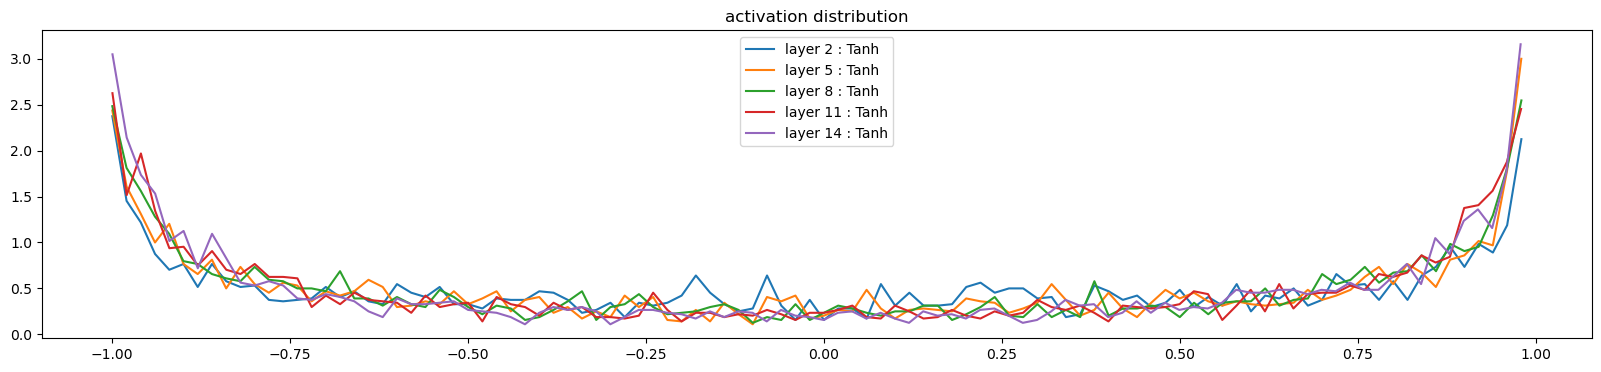

In [216]:
#visualization histogram
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.figure(figsize=(20,4)) 
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} : {layer.__class__.__name__}')

plt.legend(legends)
plt.title("activation distribution")


Text(0.5, 1.0, 'Loss over training set')

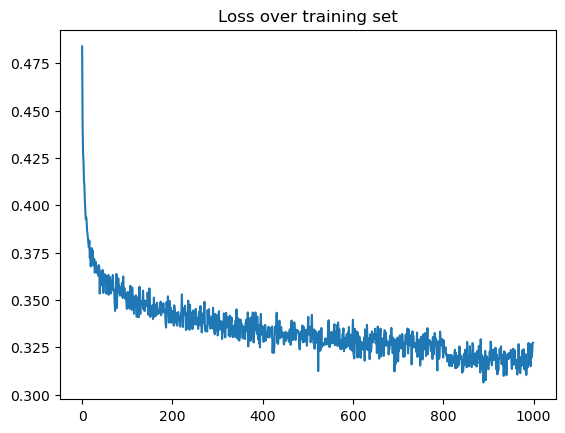

In [230]:
lossi = lossi[:100000]
plt.plot((torch.tensor(lossi).view(-1,100)).mean(1))
plt.title("Loss over training set")

layer 2 (      Tanh): mean -0.000000, std 4.181396e-03
layer 5 (      Tanh): mean +0.000000, std 4.178647e-03
layer 8 (      Tanh): mean -0.000000, std 4.141080e-03
layer 11 (      Tanh): mean +0.000000, std 3.907927e-03
layer 14 (      Tanh): mean +0.000000, std 3.837187e-03


Text(0.5, 1.0, 'gradient distribution')

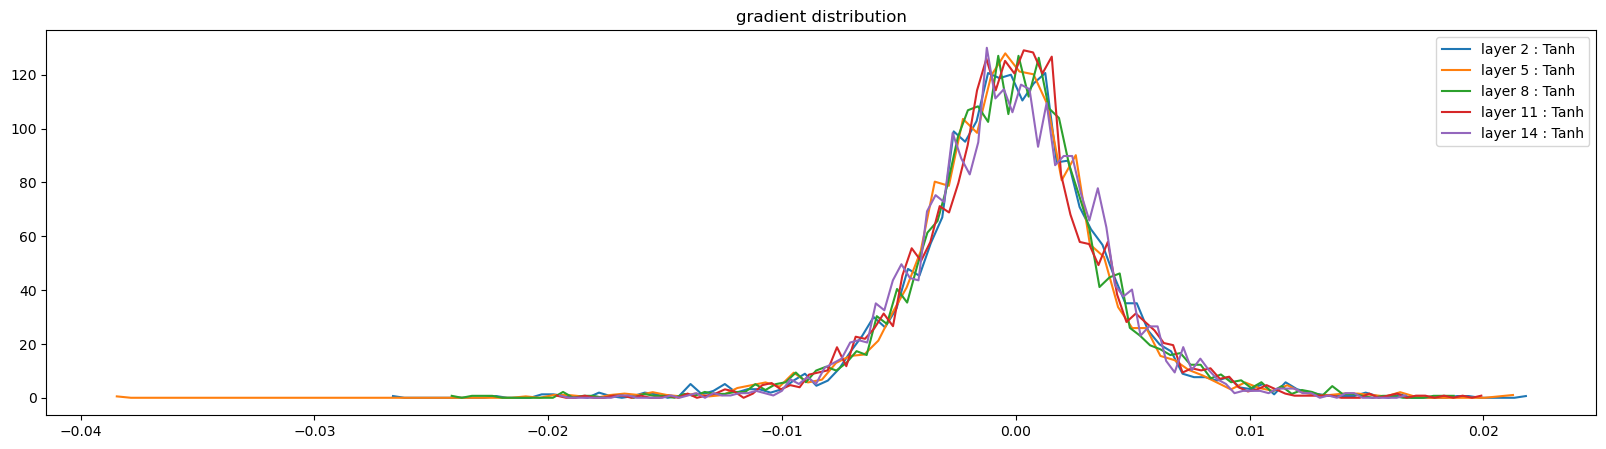

In [231]:
plt.figure(figsize=(20,5)) 
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} : {layer.__class__.__name__}')

plt.legend(legends)
plt.title("gradient distribution")

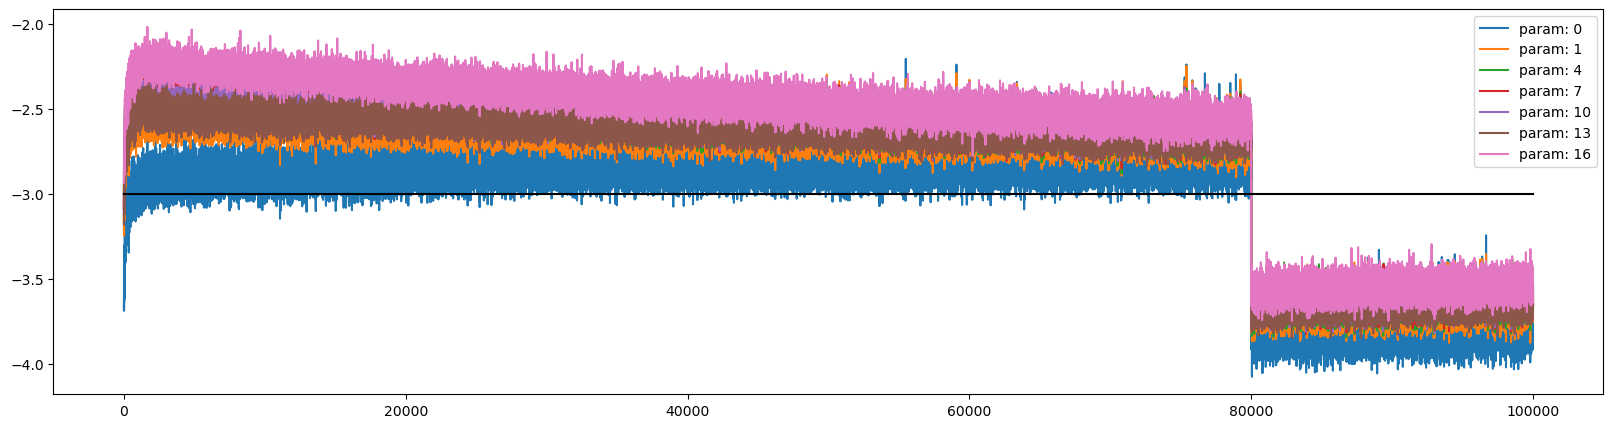

In [232]:
#data update ratio
plt.figure(figsize=(20,5))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param: {i}')
plt.plot([0,len(ud)], [-3,-3], 'k')
plt.legend(legends)

In [233]:
@torch.no_grad #decorative to inform stop calculating gradient
def print_split(split):
    X,Y = {'train' : (X_trn, Y_trn),
           'valid': (X_val, Y_val),
           'test' : (X_test, Y_test),
           }[split]

    emb = C[X]
    #forward pass
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y)
    print(split, loss.item())

#model in eval mode
for layer in layers:
    layer.Training = False

print_split('valid')
print_split('test')

valid 2.0935497283935547
test 2.0933327674865723


In [236]:

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * batch_size

    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0],-1)

        with torch.no_grad():
            for layer in layers:
                x = layer(x)
                #print(x)
        logits = x
        #print(logits)
        prob = F.softmax(logits, dim=1)
        #print(prob)

        ix = torch.multinomial(prob, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix==0:
            break

    print( ''.join(itos[i] for i in out))

jirysiel.
shawsi.
osley.
javon.
becnamin.
kwyldan.
ade.
den.
aurikso.
altison.
katraylin.
bri.
valon.
marel.
arol.
neam.
jour.
mer.
brixhangel.
maddys.
